Step = 0 Cost = 2.7761318113048556
Step = 10 Cost = 0.00040623700556277116
Step = 20 Cost = 4.678583039508945e-06
Step = 30 Cost = 5.393972476625017e-08
Step = 40 Cost = 6.218825978813115e-10
Step = 50 Cost = 7.169818190059447e-12
Step = 60 Cost = 8.26623758088152e-14
Step = 70 Cost = 9.5303229989269e-16
Step = 80 Cost = 1.0987717725932827e-17
Step = 90 Cost = 1.266798881239017e-19


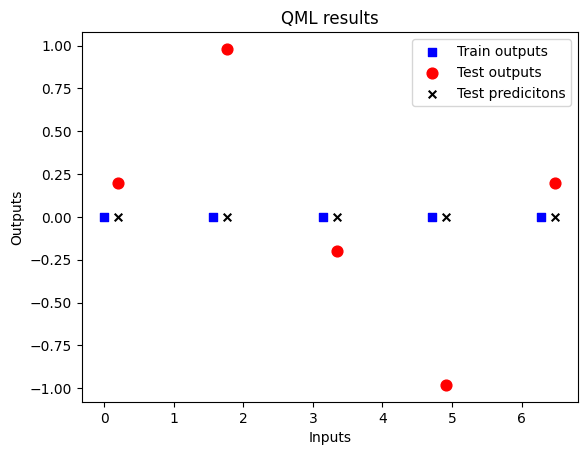

In [3]:
# In this program we will train a circuit to model a sine function

# We import the necessary libraries
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We create the training Data
X = np.linspace(0, 2*np.pi, 5) # 5 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
X.requires_grad = False
Y = np.sin(2*X) # The outputs for the input datapoints

# We create the test Data
# 5 test datapoints, shifted from the training data by 0.2
# Since we're not optimizing over the test data we
# don't need to specify requires_grad = False
X_test = np.linspace(0.2, 2*np.pi+0.2, 5)
Y_test = np.sin(X_test) # The outputs for the test datapoints

# Step 1 - Create the device
# Here we use the 'default.qubit' simulator and 1 qubit (wires=1)
dev = qml.device('default.qubit', wires=1)

# Step 2 - Create the quantum circuit
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

# Step 3 - Classical Pre/Postprocessing
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.

    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

# Step 4 - Define your cost function, including any classical pre/postprocessing
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    predictions = [quantum_circuit(x, params)  for x in X]
    # We calculate the cost including any classical postprocessing
    cost = loss_func(predictions)
    return cost

# Steps 5.1 and 5.2  - We define the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.3)

# Step 5.3 We make an initial guess for the parameters
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Step 5.4 - We iterate over a number of defined steps (100)
for i in range (100):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {cost_fn(params)}')

# Step 6 - Test and graph your results!
test_predictions = []
for x_test in X_test:
    prediction = quantum_circuit(x_test,params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()